In [90]:
# import all necessary packages
import warnings 
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import time
import os
import cv2
import h5py

In [91]:
import keras
from keras import models
from keras import layers
from keras import optimizers

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.losses import categorical_crossentropy
from keras.models import Model
from keras.models import load_model
from keras.preprocessing import image
from keras.utils.vis_utils import plot_model
from mpl_toolkits.axes_grid1 import ImageGrid

import tensorflow as tf

In [92]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions

In [93]:
# this is original image dataset for left hand driving
class_list =  ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6','c7', 'c8', 'c9']
left_class_desc = ['safe driving', 'texting-right', 'talking on the phone-right', 'texting-left', 'talking on the phone-left', 
              'operating the radio', 'drinking', 'reaching behind', 'hair and makeup', 'talking to passenger']
right_class_desc = ['safe driving', 'texting-left', 'talking on the phone-left', 'texting-right', 'talking on the phone-right', 
              'operating the radio', 'drinking', 'reaching behind', 'hair and makeup', 'talking to passenger']
df_desc = pd.DataFrame({'class': class_list, 'left_desc': left_class_desc,  'right_desc': right_class_desc})
df_desc

,class,left_desc,right_desc
0,c0,safe driving,safe driving
1,c1,texting-right,texting-left
2,c2,talking on the phone-right,talking on the phone-left
3,c3,texting-left,texting-right
4,c4,talking on the phone-left,talking on the phone-right
5,c5,operating the radio,operating the radio
6,c6,drinking,drinking
7,c7,reaching behind,reaching behind
8,c8,hair and makeup,hair and makeup
9,c9,talking to passenger,talking to passenger


*** removed claas: 'hair and makeup', 'talking to passenger'***

# this is original image dataset for left hand driving
class_list =  ['c0', 'c1', 'c3']
left_class_desc = ['safe', 'on-phone', 'talk']
right_class_desc = ['safe', 'on-phone', 'talk']
df_desc = pd.DataFrame({'class': class_list, 'left_desc': left_class_desc,  'right_desc': right_class_desc})
df_desc

# this is original image dataset for left hand driving
class_list =  ['c0', 'c1', 'c3']
left_class_desc = ['safe', 'on-phone', 'talk']
right_class_desc = ['safe', 'on-phone', 'talk']
df_desc = pd.DataFrame({'class': class_list, 'left_desc': left_class_desc,  'right_desc': right_class_desc})
df_desc

In [94]:
print(os.listdir("../input"))

['imgs-right-4class', 'imgs-right-3class', 'imgs-right-cure-final-noise']


In [95]:
#data_dir = '../input/imgs-right-d10-cure-noise1/imgs_right_d10_cure_noise'   # For kernal
#data_dir = '../input/imgs-right-3class/imgs_right_3class'   # For kernal
data_dir = '../input/imgs-right-cure-final-noise/imgs_right_cure_final_noise'   # For kernal

#data_dir = 'D:/my_learning_dataset/state_farms_drivers/imgs_right_4class' 

#data_dir = 'D:/my_learning_dataset/state_farms_drivers/imgs_right_created_noise/'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

INPUT_SIZE = 128  # to experiment with higher pixel size
model_name = "vgg16_model_ssim_size128"

In [96]:
for classname in class_list:
    print('{}: {} images'.format(classname, len(os.listdir(os.path.join(train_dir, classname)))))

c0: 1724 images
c1: 1794 images
c2: 1793 images
c3: 1822 images
c4: 1860 images
c5: 1887 images
c6: 1795 images
c7: 1897 images
c8: 1748 images
c9: 1726 images


In [97]:
train = []
for class_id, classname in enumerate(class_list):
    for file in os.listdir(os.path.join(train_dir, classname)):
        train.append(['train/{}/{}'.format(classname, file), class_id, classname])
        
train = pd.DataFrame(train, columns=['file', 'class_id', 'classname'])
train.head(2)

,file,class_id,classname
0,train/c0/p039_img_33009.jpg,0,c0
1,train/c0/p052_img_20249.jpg,0,c0


In [98]:
num_classes = len(np.unique(train["class_id"]))
print("num of classes: ", num_classes)
print("Training dataset shape: ",train.shape)

num of classes:  10
Training dataset shape:  (18046, 3)


test = []
for file in os.listdir(test_dir):
    test.append(['test/{}'.format(file), file])
test = pd.DataFrame(test, columns=['filepath', 'file'])
print("Testing dataset shape: ", test.shape)
test.head(2)

In [99]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

target = train["class_id"]

# split dataset into training and validation data with 70:30 split
test_size = 0.30 # taking 70:30 training and test set
seed = 7  # Random numbmer seeding for reapeatability of the code
X_train, X_val, y_train, y_val = train_test_split(train, target, test_size=test_size, random_state=seed)

# pls note X_train & X_test contain the records of image file.. later we will read these images
# and converted into image data(i.e pixel) for further processing

In [100]:
print("Training shape: {}".format(X_train.shape))
print("Validation shape: {}".format(X_val.shape))

Training shape: (12632, 3)
Validation shape: (5414, 3)


In [101]:
def read_image_keras(filepath, size):
    img = image.load_img(filepath, target_size=size)
    img = image.img_to_array(img) # convert the image pixels to a numpy array
    # Convert the image / images into batch format
    # expand_dims will add an extra dimension to the data at a particular axis
    # We want the input matrix to the network to be of the form (batchsize, height, width, channels)
    # Thus we add the extra dimension to the axis 0.
    img = np.expand_dims(img, axis=0) # reshape data for the model
    return img

def read_image_cv2(filepath, size):
    img = cv2.imread(filepath) #, cv2.IMREAD_GRAYSCALE
    img = cv2.resize(img, size, interpolation = cv2.INTER_AREA) # resize image  
    img = image.img_to_array(img) # convert the image pixels to a numpy array
    # Convert the image / images into batch format
    # expand_dims will add an extra dimension to the data at a particular axis
    # We want the input matrix to the network to be of the form (batchsize, height, width, channels)
    # Thus we add the extra dimension to the axis 0.
    img = np.expand_dims(img, axis=0) # reshape data for the model
    return img

def vgg_read_image(filepath, size):
    img = read_image_cv2(filepath, size)
    img_preprocessed = preprocess_input(img.copy()) # # prepare the image for the VGG model
    return img_preprocessed

In [102]:
start = time.time()
# reading image file for traing dataset
X_train_features = np.zeros((len(X_train), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, file in enumerate(X_train['file']):
    filepath = os.path.join(data_dir, file)
    X_train_features[i] = vgg_read_image(filepath, (INPUT_SIZE, INPUT_SIZE))

end = time.time()
execution_dur = end - start;
print("execution time: %0.2f minutes" %(execution_dur/60))
print('Training Images shape: {} size: {:,}'.format(X_train_features.shape, X_train_features.size))

execution time: 1.28 minutes
Training Images shape: (12632, 128, 128, 3) size: 620,888,064


In [103]:
start = time.time()
# reading image file for validation dataset
X_val_features = np.zeros((len(X_val), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, file in enumerate(X_val['file']):
    filepath = os.path.join(data_dir, file)
    X_val_features[i] = vgg_read_image(filepath, (INPUT_SIZE, INPUT_SIZE))

end = time.time()
execution_dur = end - start;
print("execution time: %0.2f minutes" %(execution_dur/60))
print('Validation Images shape: {} size: {:,}'.format(X_val_features.shape, X_val_features.size))

execution time: 0.65 minutes
Validation Images shape: (5414, 128, 128, 3) size: 266,108,928


In [104]:
# normalize inputs from 0-255 to 0-1
X_train_features = X_train_features.astype('float32')/255
X_val_features = X_val_features.astype('float32')/255

In [105]:
# dataset have 12 classes and each label is an integer between 0 and 11:
y_train_cat = keras.utils.to_categorical(y_train, num_classes=num_classes)
y_val_cat = keras.utils.to_categorical(y_val, num_classes=num_classes)

print(y_train_cat.shape)
print('First 5 examples are: \n', y_train_cat[0:5])

(12632, 10)
First 5 examples are: 
 [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


In [106]:
# input size
print("Training data shape:")
print("Features: ",X_train_features.shape)
print("Target: ",y_train_cat.shape)

# validation size
print("\nValidation data shape:")
print("Features: ",X_val_features.shape)
print("Target: ",y_val_cat.shape)

Training data shape:
Features:  (12632, 128, 128, 3)
Target:  (12632, 10)

Validation data shape:
Features:  (5414, 128, 128, 3)
Target:  (5414, 10)


In [107]:
# input image dimensions
num_train, img_rows, img_cols, img_channels =  X_train_features.shape
input_shape = (img_rows, img_cols, img_channels)
print("input shape: ", input_shape)

num_classes = y_train_cat.shape[1]
print("num_classes: ",num_classes)

input shape:  (128, 128, 3)
num_classes:  10


In [108]:

# utility fxn to plot model history and accuracy for each epoch
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
# utiliy fxn to get y_predict in 1D
# y_predict is array of 12 classes for each cases.. let form the new data which give label value in 1D.. 
# this is required for classification matrix.. cm expect 1D array
def get1D_y_predict(y_pred):
    result = []
    for i in range(len(y_pred)):
        result.append(np.where(y_pred[i] == np.max(y_pred[i]))[0][0])
    return result    

def plot_cnf_matrix(cnf_matrix, name):
    fig, ax = plt.subplots(1, figsize=(12,5))
    ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
    ax.set_xticklabels(class_list)
    ax.set_yticklabels(class_list)
    plt.title('Confusion Matrix')
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    fig.savefig('{}.png'.format(name), dpi=300)
    plt.show();
    
# use tensorboard callback which will passed in model.fit function.
# utility fxn ffor Initializing Early stopping and Model chekpoint callbacks**
def EarlyStopingModelCheckPoint():
    #tensorboard = TensorBoard(log_dir=".logs/{}".format(time.time()))

    #Adding Early stopping callback to the fit function is going to stop the training,
    #if the val_loss is not going to change even '0.001' for more than 5 continous epochs

    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)

    #Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves 
    # a new low value. Hence saving the best weights occurred during training

    #model_checkpoints/model_checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5
    filename = "{}_best.h5".format(model_name)
    model_checkpoint =  ModelCheckpoint(filename,
                                           monitor='val_loss',
                                           verbose=1,
                                           save_best_only=True,
                                           mode='auto',
                                           period=1)
    return early_stopping, model_checkpoint

In [109]:
# load a VGG model without the top layer ( which consists of fully connected layers )
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channels))

In [110]:
#from keras.models import load_model
#filepath = '../input/vgg16-weights-tf-dim/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'   # For kernal
#vgg_conv = load_model(filepath)

***vgg model: ***
https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

In [111]:
vgg_conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [112]:
# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False
 
# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fe54c423400> False
<keras.layers.convolutional.Conv2D object at 0x7fe54c4231d0> False
<keras.layers.convolutional.Conv2D object at 0x7fe54c423128> False
<keras.layers.pooling.MaxPooling2D object at 0x7fe54c423630> False
<keras.layers.convolutional.Conv2D object at 0x7fe54c423a58> False
<keras.layers.convolutional.Conv2D object at 0x7fe54c126da0> False
<keras.layers.pooling.MaxPooling2D object at 0x7fe54c2d7470> False
<keras.layers.convolutional.Conv2D object at 0x7fe54c2d76d8> False
<keras.layers.convolutional.Conv2D object at 0x7fe54c255e80> False
<keras.layers.convolutional.Conv2D object at 0x7fe54c205b38> False
<keras.layers.pooling.MaxPooling2D object at 0x7fe54c2fd358> False
<keras.layers.convolutional.Conv2D object at 0x7fe54c2fd278> False
<keras.layers.convolutional.Conv2D object at 0x7fe54c1bd160> False
<keras.layers.convolutional.Conv2D object at 0x7fe54c130550> False
<keras.layers.pooling.MaxPooling2D object at 0x7fe54c0a74e0>

In [113]:
# Create the model
my_model = models.Sequential()
 
# Add the vgg convolutional base model
my_model.add(vgg_conv)
 
# Add new layers
my_model.add(layers.Flatten())
#my_model.add(layers.BatchNormalization())
my_model.add(layers.Dense(1024, activation='relu'))
my_model.add(layers.Dropout(0.5))
my_model.add(layers.Dense(512, activation='relu'))
my_model.add(layers.Dense(num_classes, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
my_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_11 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 1024)              8389632   
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_23 (Dense)             (None, 10)                5130      
Total params: 23,634,250
Trainable params: 15,998,986
Non-trainable params: 7,635,264
_________________________________

In [114]:
# Compile the model
optimizer=optimizers.RMSprop(lr=1e-4)
#optimizer = keras.optimizers.Adam(lr=0.0001)
#optimizer = keras.optimizers.SGD(lr=0.0001)

my_model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [115]:
early_stopping, model_checkpoint = EarlyStopingModelCheckPoint()

# Train the model
start = time.time()

history = my_model.fit(X_train_features, y_train_cat, # feature and target vector
          validation_data=(X_val_features, y_val_cat), # data for evaluation
          epochs=200,
          batch_size=16, # Number of observations per batch
          verbose=1,     # Print description after each epoch
          callbacks=[early_stopping,model_checkpoint])

end = time.time()
execution_dur = end - start;

Train on 12632 samples, validate on 5414 samples
Epoch 1/200
12632/12632 [==============================] - 25s 2ms/step - loss: 0.6188 - accuracy: 0.7945 - val_loss: 0.1413 - val_accuracy: 0.9601

Epoch 00001: val_loss improved from inf to 0.14129, saving model to vgg16_model_ssim_size128_best.h5
Epoch 2/200
12632/12632 [==============================] - 25s 2ms/step - loss: 0.1653 - accuracy: 0.9567 - val_loss: 0.1519 - val_accuracy: 0.9677

Epoch 00002: val_loss did not improve from 0.14129
Epoch 3/200
12632/12632 [==============================] - 25s 2ms/step - loss: 0.1153 - accuracy: 0.9734 - val_loss: 0.1022 - val_accuracy: 0.9780

Epoch 00003: val_loss improved from 0.14129 to 0.10222, saving model to vgg16_model_ssim_size128_best.h5
Epoch 4/200
12632/12632 [==============================] - 25s 2ms/step - loss: 0.0995 - accuracy: 0.9790 - val_loss: 0.1327 - val_accuracy: 0.9719

Epoch 00004: val_loss did not improve from 0.10222
Epoch 5/200
12632/12632 [======================

In [116]:
print("Model execution time: %0.2f minutes" %(execution_dur/60))

Model execution time: 3.38 minutes


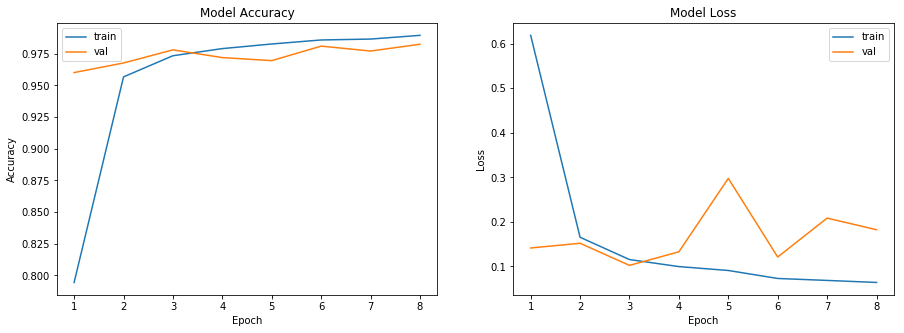

5414/5414 [==============================] - 5s 885us/step

Validation accuracy: 98.25


In [117]:
# plot model history
plot_model_history(history)

# compute accuracy for validation dataset
val_loss, val_acc = my_model.evaluate(X_val_features, y_val_cat)
print('\nValidation accuracy: %0.2f' %(val_acc*100))

In [119]:
# predict the model
y_predict = my_model.predict(X_val_features)
y_predict1D = get1D_y_predict(y_predict)
acc = metrics.accuracy_score(y_val,y_predict1D)
print('Validation accuracy: %0.2f' %(acc*100))

# classification report with model acciracy and F1 score
cr = metrics.classification_report(y_val,y_predict1D)
print("Classification Report: \n\n", cr)

Validation accuracy: 98.25
Classification Report: 

               precision    recall  f1-score   support

           0       0.99      0.95      0.97       504
           1       0.98      1.00      0.99       524
           2       0.98      1.00      0.99       510
           3       0.99      0.98      0.99       556
           4       0.98      0.98      0.98       561
           5       1.00      0.98      0.99       569
           6       0.97      0.99      0.98       562
           7       0.99      0.99      0.99       542
           8       0.98      0.97      0.97       545
           9       0.98      0.98      0.98       541

    accuracy                           0.98      5414
   macro avg       0.98      0.98      0.98      5414
weighted avg       0.98      0.98      0.98      5414



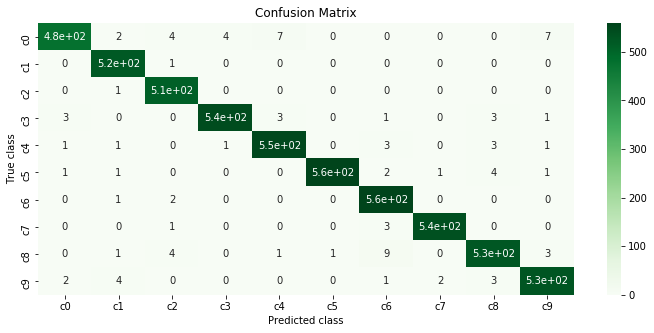

In [120]:
# confusion matrix
cm = metrics.confusion_matrix(y_val, y_predict1D)

filename = "{}_TB4B5_cnf".format(model_name)
plot_cnf_matrix(cm, filename)

In [ ]:
# Save model and weights for future use
filename = "{}.h5".format(model_name)
my_model.save(filename)

filename = "{}_weights.h5".format(model_name)
my_model.save_weights(filename)

In [121]:
import keras
keras.__version__

'2.3.0'